# **多被试分析篇** 

***

在此多被试分析篇中，按照脑电数据处理过程中可能要用到的分析技能，分为以下8个部分：

**Part 1: 基础NumPy矩阵操作  
Part 2: 基础数据读取与存储操作  
Part 3: 基础统计分析操作  
Part 4: 批处理读取与存储数据  
Part 5: 事件相关电位分析  
Part 6: 时频分析  
Part 7: 基于分类的脑电解码  
Part 8: 表征相似性分析**
    
需要用到的Python工具包包括：
**[NumPy](https://numpy.org/)**, **[h5py](http://www.h5py.org/)**, **[Scipy](https://www.scipy.org/)**, **[Matplotlib](https://matplotlib.org/stable/index.html)**, **[MNE-Python](https://mne.tools/stable/index.html)**及**[NeuroRA](https://zitonglu1996.github.io/NeuroRA/)**  
安装方法即为在命令行窗口中输入以下代码：
> pip install numpy  
> pip install h5py  
> pip install scipy  
> pip install matplotlib  
> pip install mne  
> pip install neurora  

## 导入依赖包

In [1]:
import numpy as np
import h5py
import scipy.io as sio
import matplotlib.pyplot as plt
from scipy.stats import ttest_1samp, ttest_ind, ttest_rel, f_oneway
from mne.stats import fdr_correction, f_mway_rm
from neurora.stuff import clusterbased_permutation_1d_1samp_1sided, permutation_test, \
                          clusterbased_permutation_2d_1samp_2sided, \
                          clusterbased_permutation_2d_2sided
from mne.time_frequency import tfr_array_morlet
from neurora.decoding import tbyt_decoding_kfold, ct_decoding_kfold
from neurora.rsa_plot import plot_tbyt_decoding_acc, plot_ct_decoding_acc, plot_rdm, \
                             plot_tbytsim_withstats
from neurora.rdm_cal import eegRDM
from neurora.corr_cal_by_rdm import rdms_corr

/Users/zitonglu/anaconda3/lib/python3.7/site-packages/nilearn/datasets/__init__.py:90: FutureWarning: Fetchers from the nilearn.datasets module will be updated in version 0.9 to return python strings instead of bytes and Pandas dataframes instead of Numpy arrays.
  "Numpy arrays.", FutureWarning)


# Part 1 基础NumPy矩阵操作

用Python进行数据处理时，NumPy矩阵往往是最可能用来进行分析操作的数据类型  
在第一部分，首先介绍可能在之后数据分析过程中会涉及到的一些基础而重要的NumPy矩阵操作及其实现

#### 生成固定shape的矩阵

In [2]:
# 生成shape为[3, 4]的全为0的矩阵
A = np.zeros([3, 4])
print(A.shape)
print(A)

(3, 4)
[[0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]]


In [3]:
# 生成shape为[3, 4]的全为1的矩阵
A = np.ones([3, 4])
print(A.shape)
print(A)

(3, 4)
[[1. 1. 1. 1.]
 [1. 1. 1. 1.]
 [1. 1. 1. 1.]]


In [4]:
# 生成shape为[3, 4]的随机矩阵（随机值在0-1之间）
A = np.random.rand(3, 4)
print(A.shape)
print(A)

(3, 4)
[[0.65100467 0.12865482 0.19109944 0.60468566]
 [0.12384209 0.52921762 0.10978789 0.86281498]
 [0.27202995 0.17597104 0.91011703 0.72897267]]


In [5]:
# 生成shape为[3, 4]的随机矩阵（随机值在20-80之间）
A = np.random.uniform(low=20, high=80, size=[3, 4])
print(A.shape)
print(A)

(3, 4)
[[60.48714706 77.4577087  49.09656546 69.51713397]
 [71.40449508 23.84740921 27.16549604 49.25371862]
 [56.26467795 78.35004063 52.66316452 35.7229468 ]]


#### 矩阵平铺为向量

In [6]:
A = np.ravel(A)
print(A.shape)
print(A)

(12,)
[60.48714706 77.4577087  49.09656546 69.51713397 71.40449508 23.84740921
 27.16549604 49.25371862 56.26467795 78.35004063 52.66316452 35.7229468 ]


#### 修改矩阵shape

In [7]:
# 将A的shape变为[3, 4]
A = np.reshape(A, (3, 4))
print(A.shape)
print(A)

(3, 4)
[[60.48714706 77.4577087  49.09656546 69.51713397]
 [71.40449508 23.84740921 27.16549604 49.25371862]
 [56.26467795 78.35004063 52.66316452 35.7229468 ]]


#### 矩阵转置

二维矩阵转置

In [8]:
A = A.T
print(A.shape)
print(A)

(4, 3)
[[60.48714706 71.40449508 56.26467795]
 [77.4577087  23.84740921 78.35004063]
 [49.09656546 27.16549604 52.66316452]
 [69.51713397 49.25371862 35.7229468 ]]


高维矩阵转置

In [9]:
# 先生成一个shape为[2, 3, 4]的三维矩阵
B = np.random.rand(2, 3, 4)
print(B.shape)
print(B)

(2, 3, 4)
[[[0.86226173 0.46500768 0.1174423  0.55938448]
  [0.93240423 0.54418383 0.2985849  0.98673366]
  [0.26477999 0.66429826 0.47286087 0.59543336]]

 [[0.72603365 0.75123114 0.26744374 0.46297918]
  [0.15560864 0.91204763 0.51568818 0.94772492]
  [0.69970455 0.4829181  0.5284955  0.61005708]]]


In [10]:
# 将矩阵转置为[2, 4, 3]的shape
B = np.transpose(B, (0, 2, 1))
print(B.shape)
print(B)

(2, 4, 3)
[[[0.86226173 0.93240423 0.26477999]
  [0.46500768 0.54418383 0.66429826]
  [0.1174423  0.2985849  0.47286087]
  [0.55938448 0.98673366 0.59543336]]

 [[0.72603365 0.15560864 0.69970455]
  [0.75123114 0.91204763 0.4829181 ]
  [0.26744374 0.51568818 0.5284955 ]
  [0.46297918 0.94772492 0.61005708]]]


In [11]:
# 再来一个例子，
# 将shape为[2, 4, 3]的矩阵转置为shape为[4, 3, 2]的矩阵
B = np.transpose(B, (1, 2, 0))
print(B.shape)
print(B)

(4, 3, 2)
[[[0.86226173 0.72603365]
  [0.93240423 0.15560864]
  [0.26477999 0.69970455]]

 [[0.46500768 0.75123114]
  [0.54418383 0.91204763]
  [0.66429826 0.4829181 ]]

 [[0.1174423  0.26744374]
  [0.2985849  0.51568818]
  [0.47286087 0.5284955 ]]

 [[0.55938448 0.46297918]
  [0.98673366 0.94772492]
  [0.59543336 0.61005708]]]


#### 矩阵合并

In [12]:
# 先生成一个[4, 3, 3]的矩阵
C = np.random.rand(4, 3, 3)
print(C.shape)
print(C)

(4, 3, 3)
[[[0.6529941  0.23478856 0.32296808]
  [0.76741883 0.82000021 0.07859593]
  [0.88220155 0.46746821 0.32396664]]

 [[0.83118832 0.54187684 0.39290027]
  [0.20795472 0.4925971  0.468849  ]
  [0.11813247 0.24415301 0.23444894]]

 [[0.74642119 0.66779653 0.73754652]
  [0.22930653 0.60239736 0.32041094]
  [0.59564638 0.71796893 0.45692657]]

 [[0.98179714 0.78526125 0.51181553]
  [0.8092335  0.80377571 0.32046496]
  [0.07072291 0.94284871 0.22061161]]]


In [13]:
# 将矩阵B（shape为[4, 3, 2]）与矩阵C（shape为[4, 3, 3]）合并
# 即第三个维度进行合并，合并后矩阵shape为[4, 3, 5]
D = np.concatenate((B, C), axis=2)
print(D.shape)
print(D)

(4, 3, 5)
[[[0.86226173 0.72603365 0.6529941  0.23478856 0.32296808]
  [0.93240423 0.15560864 0.76741883 0.82000021 0.07859593]
  [0.26477999 0.69970455 0.88220155 0.46746821 0.32396664]]

 [[0.46500768 0.75123114 0.83118832 0.54187684 0.39290027]
  [0.54418383 0.91204763 0.20795472 0.4925971  0.468849  ]
  [0.66429826 0.4829181  0.11813247 0.24415301 0.23444894]]

 [[0.1174423  0.26744374 0.74642119 0.66779653 0.73754652]
  [0.2985849  0.51568818 0.22930653 0.60239736 0.32041094]
  [0.47286087 0.5284955  0.59564638 0.71796893 0.45692657]]

 [[0.55938448 0.46297918 0.98179714 0.78526125 0.51181553]
  [0.98673366 0.94772492 0.8092335  0.80377571 0.32046496]
  [0.59543336 0.61005708 0.07072291 0.94284871 0.22061161]]]


In [14]:
# 再来一个例子
# 生成一个shape为[1, 3, 2]的矩阵E
# 合并矩阵B和矩阵E，得到shape为[5, 3, 2]的矩阵F
E = np.random.rand(1, 3, 2)
F = np.concatenate((B, E), axis=0)
print(F.shape)
print(F)

(5, 3, 2)
[[[0.86226173 0.72603365]
  [0.93240423 0.15560864]
  [0.26477999 0.69970455]]

 [[0.46500768 0.75123114]
  [0.54418383 0.91204763]
  [0.66429826 0.4829181 ]]

 [[0.1174423  0.26744374]
  [0.2985849  0.51568818]
  [0.47286087 0.5284955 ]]

 [[0.55938448 0.46297918]
  [0.98673366 0.94772492]
  [0.59543336 0.61005708]]

 [[0.7890223  0.12021067]
  [0.98221792 0.95239092]
  [0.40120652 0.44220639]]]


#### 对矩阵中的值进行平均

In [15]:
# 将矩阵B（shape为[4, 3, 2]）的第二个维度的值进行平均
B_mean = np.average(B, axis=1)
print(B_mean.shape)
print(B_mean)

(4, 2)
[[0.68648198 0.52711561]
 [0.55782992 0.71539895]
 [0.29629603 0.43720914]
 [0.7138505  0.67358706]]


#### 数据转为NumPy矩阵格式

In [16]:
G = [[1, 2], [3, 4]]
G_narry = np.array(G)
print(type(G))
print(type(G_narry))

<class 'list'>
<class 'numpy.ndarray'>


# Part 2 基础数据读取与存储操作

这部分，会介绍一些基本的基于Python用于数据（矩阵）读取与存储操作

### 基于MNE的数据读取

参考“单被试预处理篇”中的”Step 1 读取数据”和“Step 8 提取数据”部分

### 使用h5py存储数据与读取数据

h5py库可以将数据存储为一种压缩性能很强的HDF5格式文件  
HDF5文件与MATLAB中的mat文件类似  
都是通过Key和dataset构成  
Key可以理解成数据的名称，dataset可以理解具体的数据  
但是HDF5具有比mat更强的压缩性能  
HDF5文件的后缀为.h5

#### 使用h5py存储数据

In [17]:
# 生成一个数据，其shape为[4, 5]
testdata = np.random.rand(4, 5)
# 调用h5py，将数据存为一个名为'test_data.h5'文件
f = h5py.File('test_data.h5', 'w')
# 使用Key+dataset的方式存储上述testdata矩阵，这里Key命名为'data'
f.create_dataset('data', data=testdata)
# 关闭调用
f.close()

#### 使用h5py读取数据

In [18]:
# 读取数据
testdata = np.array(h5py.File('test_data.h5', 'r')['data'])
# 打印读取的数据
print(testdata.shape)
print(testdata)

(4, 5)
[[0.09419485 0.38551604 0.71869913 0.72355288 0.03662613]
 [0.35830827 0.76030518 0.65722008 0.53330149 0.59620509]
 [0.4940634  0.58979175 0.05720484 0.96410785 0.15992315]
 [0.71618164 0.75338382 0.61259263 0.61647119 0.81822889]]


### 使用NumPy存储矩阵与读取

NumPy自带的save()可以将二维矩阵存为.npy文件  
其自带的loadtxt()则可以读取.npy文件中的数据

使用NumPy存储矩阵数据

In [19]:
# 将NumPy Array格式的矩阵testdata存成一个名为'test_data.npy'的文件
np.save('test_data.npy', testdata)

使用NumPy读取.npy文件存储为NumPy矩阵数据

In [20]:
# 读取'test_data.npy'文件存储的数据
testdata = np.load('test_data.npy')
# 打印读取的数据
print(testdata.shape)
print(testdata)

(4, 5)
[[0.09419485 0.38551604 0.71869913 0.72355288 0.03662613]
 [0.35830827 0.76030518 0.65722008 0.53330149 0.59620509]
 [0.4940634  0.58979175 0.05720484 0.96410785 0.15992315]
 [0.71618164 0.75338382 0.61259263 0.61647119 0.81822889]]


### 使用NumPy存储二维矩阵与读取

NumPy自带的savetxt()可以将二维矩阵存为.txt文件  
其自带的loadtxt()则可以读取.txt文件中的数据

使用NumPy存储二维矩阵数据

In [21]:
# 将NumPy Array格式的矩阵testdata存成一个名为'test_data.txt'的文件
np.savetxt('test_data.txt', testdata)

使用NumPy读取.txt文件存储的二维矩阵数据

In [22]:
# 读取'test_data.txt'文件存储的数据
testdata = np.loadtxt('test_data.txt')
# 打印读取的数据
print(testdata.shape)
print(testdata)

(4, 5)
[[0.09419485 0.38551604 0.71869913 0.72355288 0.03662613]
 [0.35830827 0.76030518 0.65722008 0.53330149 0.59620509]
 [0.4940634  0.58979175 0.05720484 0.96410785 0.15992315]
 [0.71618164 0.75338382 0.61259263 0.61647119 0.81822889]]


由于上述基于NumPy的方法仅适用于二维数据  
若实在想存储多维数据，可以先reshape为二维数据再进行存储  
以下代码为一个示例：

In [23]:
# 生成一个三维数据，其shape为[2, 3, 4]
testdata_3d = np.random.rand(2, 3, 4)
# reshape成[2, 12]
testdata_3d_to_2d = np.reshape(testdata_3d, (2, 12))
# 存储数据为.txt文件
np.savetxt('test_data_3d_to_2d.txt', testdata_3d_to_2d)
# 读取数据
testdata_2d = np.loadtxt('test_data_3d_to_2d.txt')
# reshape成[2, 3, 4]
testdata_2d_to_3d = np.reshape(testdata_2d, (2, 3, 4))

### 将.mat文件读为NumPy矩阵

Python中读取MATLAB下的.mat格式文件，主要通过以下两种方式：

#### 使用Scipy.io读取  
以下代码仅为示例，无实际数据  
filename为待读入.mat文件的地址，Key为待读入数据的Key
> import scipy.io as sio  
> data = np.array(sio.loadmat(filename)[Key])

#### 使用h5py读取  
h5py也可以用来读取.mat文件，与读取.h5文件的步骤相同  
上述已经介绍过，以下代码仅为示例，无实际数据  
> import h5py  
> data = np.array(h5py.File(filename, 'r')[Key])

# Part 3 基础统计分析操作

在预处理教程中，对单个被试的数据可视化都可以用MNE自带的函数进行  
并且通过输入单个被试所有的epoch数据，即可展示出某条件下所有epoch的均值  
然而，在进行多被试数据群组分析时，往往需要自己能够动手进行一系列的统计操作

### 描述统计

首先，介绍以几个常用描述统计指标的计算方法:  
* 均值(mean)
* 方差(variance)
* 标准差(standard deviation)
* 标准误差(standard error)

这里，生成一些虚假的脑电数据进行后续统计分析示例  
假设随机生成如下的100个被试的从-200ms到1000ms（1200个时间点，每个点对应1ms）的事件相关电位（ERP）数据  

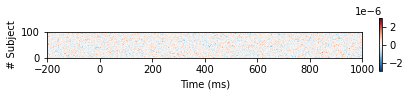

In [24]:
# 生成虚假脑电数据，其shape为[100, 1200]
data = np.random.uniform(low=-3e-6, high=3e-6, size=(100, 1200))
# 逐trial可视化
plt.imshow(data, extent=[-200, 1000, 0, 100], cmap='RdBu_r')
plt.colorbar(fraction=0.008, ticks=[-2e-6, 0, 2e-6])
plt.xlabel('Time (ms)')
plt.ylabel('# Subject')
plt.show()

计算200个被试的ERP的均值

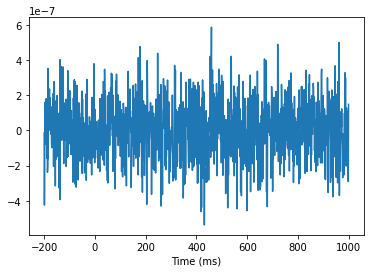

In [25]:
# 对epoch的维度进行平均
data_mean = np.mean(data, axis=0)
times = np.arange(-200, 1000)
# 对均值可视化
plt.plot(times, data_mean)
plt.xlabel('Time (ms)')
plt.show()

计算200个被试的ERP的方差VAR

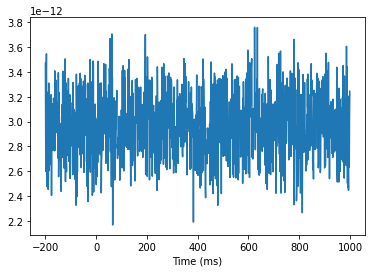

In [26]:
data_var = np.var(data, axis=0)
plt.plot(times, data_var)
plt.xlabel('Time (ms)')
plt.show()

计算200个被试的ERP的标准差STD

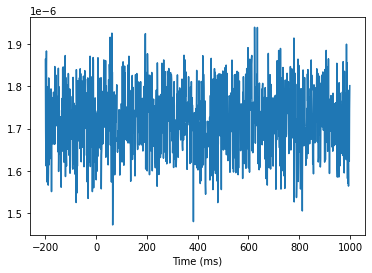

In [27]:
data_std = np.std(data, axis=0)
plt.plot(times, data_std)
plt.xlabel('Time (ms)')
plt.show()

计算200个被试的ERP的标准误SEM

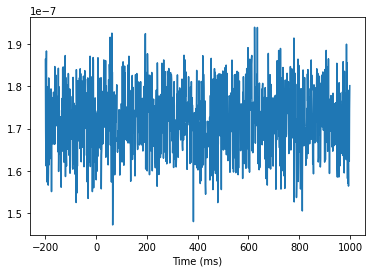

In [28]:
n_subjects = 100
data_sem = np.std(data, axis=0, ddof=0)/np.sqrt(n_subjects)
plt.plot(times, data_sem)
plt.xlabel('Time (ms)')
plt.show()

### 推断统计

在EEG研究中，除了对脑电数据的均值和离散程度进行计算外，还经常涉及到对总体特征的一些推断  
对一些基本概念不再赘述，下面仅对常用的显著性检验方法进行介绍

#### 对单样本进行检验
当需要检验某一条件下的数据是否显著与某个特定的值不同，常使用单样本*t*检验或置换检验(permutation_test)

这里，类上例再次随机生成20个被试的1200个时间点的数据进行后续示例

In [29]:
# 生成随机范围在-0.1到0.4之间的shape为[20, 1200]的数据
data = np.random.uniform(low=-0.5, high=0.55, size=(20, 1200))

##### 参数检验方法 单样本*t*检验（未矫正）

进行逐时间点假设数据的值大于0的统计检验

(1200,)


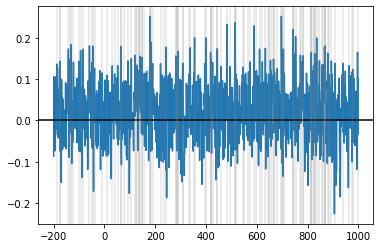

In [30]:
# 单样本t检验
t_vals, p_vals = ttest_1samp(data, 0, axis=0, alternative='greater')
# 打印出p_vals的shape：[1200]对应1200个时间点
print(np.shape(p_vals))
# 可视化统计检验后结果
# 阴影竖线代表显著的时间点
plt.plot(times, np.average(data, axis=0))
plt.axhline(y=0, color='black')
for i, p_val in enumerate(p_vals):
    if p_val < 0.05:
        plt.axvline(x=times[i], color='grey', alpha=0.2)
plt.show()

##### 非参数检验方法 置换检验 permutation test（未矫正）

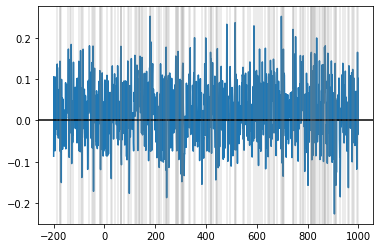

In [31]:
# NeuroRA的stuff模块下的permutation_test()函数能做两样本间的置换检验
# 生成一个shape为[20]的全0向量
zeros = np.zeros([20])
# 初始化一个p_vals用于存储计算得到的p值
p_vals = np.zeros([1200])
# 逐时间点计算p值
for t in range(1200):
    p_vals[t] = permutation_test(data[:, t], zeros)
# 可视化统计检验后结果
plt.plot(times, np.average(data, axis=0))
plt.axhline(y=0, color='black')
for i, p_val in enumerate(p_vals):
    if p_val < 0.05:
        plt.axvline(x=times[i], color='grey', alpha=0.2)
plt.show()

但若进行探索性分析时，希望找到有显著差异的时间点，这时需要对结果进行校正以避免多重比较带来的假阳性  
常用的方法有以下三种：  
- 控制族错误率（familywise error rate, FWER）的Bonferroni校正
- 控制错误发现率（False discovery rate, FDR）的FDR校正
- 基于cluster的置换检验（cluster-based permutation test）

##### Bonferroni（FWER）矫正

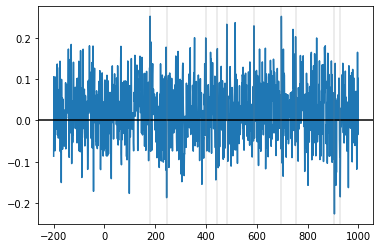

In [32]:
# Bonferrorni校正只需要把p值乘以进行统计检验的次数
# 这里即乘以时间点数
p_bf_corrected_vals = p_vals*len(times)
# 可视化经过矫正的统计检验结果
plt.plot(times, np.average(data, axis=0))
plt.axhline(y=0, color='black')
for i, p_val in enumerate(p_bf_corrected_vals):
    if p_val < 0.05:
        plt.axvline(x=times[i], color='grey', alpha=0.2)
plt.show()

##### FDR矫正

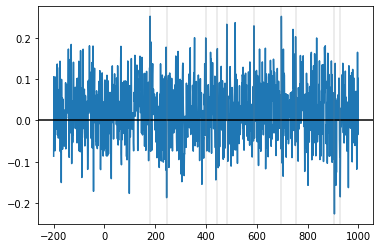

In [33]:
# FDR校正可以使用MNE中stats模块下的fdr_correlation()函数实现
# 其第一个返回值为是否通过矫正的布尔型数组（True为矫正后仍显著），第二个返回值为矫正后的p值
rejects, p_fdr_corrected_vals = fdr_correction(p_vals, alpha=0.05)
# 可视化经过矫正的统计检验结果
plt.plot(times, np.average(data, axis=0))
plt.axhline(y=0, color='black')
for i, p_val in enumerate(p_fdr_corrected_vals):
    if p_val < 0.05:
        plt.axvline(x=times[i], color='grey', alpha=0.2)
plt.show()

##### Cluster-based permutation test


Permutation test
Calculating: [====================================================================================================] 100.00%
Cluster-based permutation test finished!



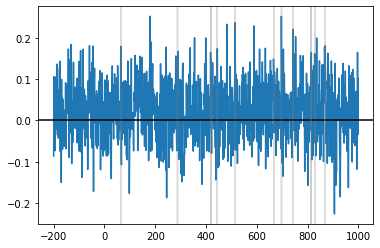

In [34]:
# 这里时序（1维）数据的单样本单边Cluster-based permutation test
# 可以通过NeuroRA中stuff模块下clusterbased_permutation_1d_1samp_1sided()函数
# 其需要输入的是用来做统计的数据（即这里的data），输出是是矫正后是否显著的矩阵（1为显著的点）
# 这里先使用p<0.05的阈值来选取clusters，对应参数设置为p_threshold=0.05
# 再用p<0.05的阈值来进行基于cluster的矫正，对应参数为clusterp_threshold=0.05
rejects = clusterbased_permutation_1d_1samp_1sided(data, level=0, 
                                                   p_threshold=0.05, 
                                                   clusterp_threshold=0.05)
# 可视化经过矫正的统计检验结果
plt.plot(times, np.average(data, axis=0))
plt.axhline(y=0, color='black')
for i, reject in enumerate(rejects):
    if reject == 1:
        plt.axvline(x=times[i], color='grey', alpha=0.2)
plt.show()

#### 比较两样本间是否有差异

当需要比较两个条件下的脑活动是否存在显著差异时  
可以使用独立样本*t*检验(条件为被试间变量)、配对样本*t*检验（条件为被试内变量）、置换检验

##### 参数检验方法 独立样本*t*检验 （FDR 校正）

这里随机生成两组‘伪’脑电数据  
假设它们分别为正常人组（对应data1）和病人组（对应data2）的数据  
正常人组有20个被试，病人组有18个被试，epoch长度依然为1200ms（1200个时间点，从-200ms到1000ms）

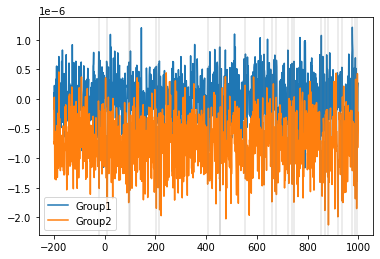

In [35]:
# 生成随机数据
data1 = np.random.uniform(low=-3e-6, high=3e-6, size=(20, 1200))
data2 = np.random.uniform(low=-4e-6, high=2.5e-6, size=(18, 1200))
# 独立样本t检验
t_vals, p_vals = ttest_ind(data1, data2, axis=0)
# FDR矫正
rejects, p_fdr_corrected = fdr_correction(p_vals, alpha=0.05)
# 可视化经过矫正的统计检验结果
plt.plot(times, np.average(data1, axis=0), label='Group1')
plt.plot(times, np.average(data2, axis=0), label='Group2')
for i, reject in enumerate(rejects):
    if reject == True:
        plt.axvline(x=times[i], color='grey', alpha=0.2)
plt.legend()
plt.show()

##### 参数检验方法 配对样本*t*检验 （FDR 校正）

这里随机生成两组‘伪’脑电数据  
假设它们分别为同一组被试在不同条件下的数据（条件1对应data1，条件2对应data2）    
被试数为20，epoch长度依然为1200ms（1200个时间点，从-200ms到1000ms）

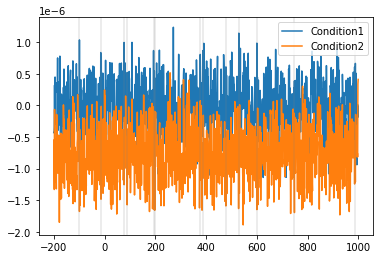

In [36]:
# 生成随机数据
data1 = np.random.uniform(low=-3e-6, high=3e-6, size=(20, 1200))
data2 = np.random.uniform(low=-4e-6, high=2.5e-6, size=(20, 1200))
# 独立样本t检验
t_vals, p_vals = ttest_rel(data1, data2, axis=0)
# FDR矫正
rejects, p_fdr_corrected = fdr_correction(p_vals, alpha=0.05)
# 可视化经过矫正的统计检验结果
plt.plot(times, np.average(data1, axis=0), label='Condition1')
plt.plot(times, np.average(data2, axis=0), label='Condition2')
for i, reject in enumerate(rejects):
    if reject == True:
        plt.axvline(x=times[i], color='grey', alpha=0.2)
plt.legend()
plt.show()

##### 非参数检验方法 置换检验 （FDR矫正）

使用上例（配对样本*t*检验）的假数据示例

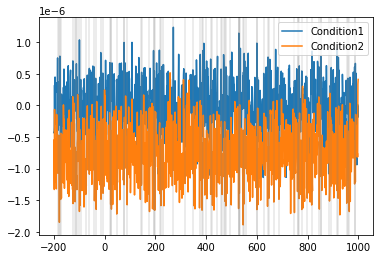

In [37]:
# 初始化一个p_vals用于存储计算得到的p值
p_vals = np.zeros([1200])
# 逐时间点计算p值
for t in range(1200):
    p_vals[t] = permutation_test(data1[:, t], data2[:, t])
# FDR矫正
rejects, p_fdr_corrected = fdr_correction(p_vals, alpha=0.05)
# 可视化经过矫正的统计检验结果
plt.plot(times, np.average(data1, axis=0), label='Condition1')
plt.plot(times, np.average(data2, axis=0), label='Condition2')
for i, reject in enumerate(rejects):
    if reject == 1:
        plt.axvline(x=times[i], color='grey', alpha=0.2)
plt.legend()
plt.show()

#### 对比多个条件间有无显著差异

##### 参数检验方法 单因素*F*检验 (FDR 校正)

这里，类似前例，生成同一组被试在三种不同实验条件下的"伪"脑电数据（分别对应data1、data2和data3）  
被试量为20，epoch长度为1200ms（1200个时间点，从-200ms到1000ms）

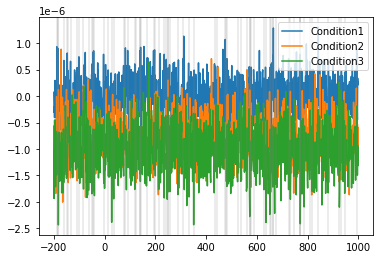

In [38]:
# 生成随机数据
data1 = np.random.uniform(low=-3e-6, high=3e-6, size=(20, 1200))
data2 = np.random.uniform(low=-4e-6, high=2.5e-6, size=(20, 1200))
data3 = np.random.uniform(low=-4.5e-6, high=2.5e-6, size=(20, 1200))
# 单因素F检验
f_vals, p_vals = f_oneway(data1, data2, data3, axis=0)
# FDR矫正
rejects, p_fdr_corrected = fdr_correction(p_vals, alpha=0.05)
# 可视化经过矫正的统计检验结果
plt.plot(times, np.average(data1, axis=0), label='Condition1')
plt.plot(times, np.average(data2, axis=0), label='Condition2')
plt.plot(times, np.average(data3, axis=0), label='Condition3')
for i, reject in enumerate(rejects):
    if reject == True:
        plt.axvline(x=times[i], color='grey', alpha=0.2)
plt.legend()
plt.show()

#### 多因素设计：两因素的交互作用和主效应

有时，我们不止要比较某个因素下几个条件的差异，也要考虑不同因素的交互作用  
这里仅介绍一种常用的参数检验方法：方差分析（ANOVA），来进行两个不同因素对脑活动影响的显著性检验

##### 参数检验方法 2×2重复测量方差分析（FDR矫正）

假设有两个被试内变量：A和B  
A有两个水平：A1, A2; B有两个水平：B1, B2  
这里类似上面，随机生一组被试4种条件下（A1B1、A1B2、A2B1、A2B2）的"伪"脑电数据  
被试数为200，epoch长度为1200ms（1200个时间点，从-200ms到1000ms）

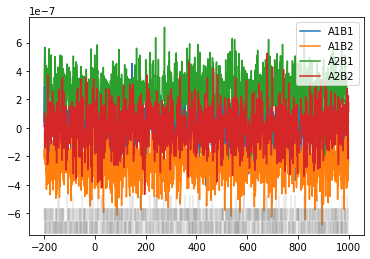

In [39]:
# 生成随机数据
data_A1B1 = np.random.uniform(low=-3e-6, high=3e-6, size=(200, 1200))
data_A1B2 = np.random.uniform(low=-3.5e-6, high=3e-6, size=(200, 1200))
data_A2B1 = np.random.uniform(low=-3e-6, high=3.5e-6, size=(200, 1200))
data_A2B2 = np.random.uniform(low=-3.5e-6, high=3.5e-6, size=(200, 1200))
# 首先对数据进行reshape方便后续合并
reshaped_A1B1 = data_A1B1.reshape(200, 1, 1200)
reshaped_A1B2 = data_A1B2.reshape(200, 1, 1200)
reshaped_A2B1 = data_A2B1.reshape(200, 1, 1200)
reshaped_A2B2 = data_A2B2.reshape(200, 1, 1200)
# 把数据按照两个因素的顺序（A1B1、A1B2、A2B1、A2B2）合并
data_combine = np.concatenate((reshaped_A1B1, reshaped_A1B2, 
                               reshaped_A2B1, reshaped_A2B2), axis=1)
# 设置变量水平
factor_levels = [2, 2]
# 使用MNE的f_mway_rm函数进行2×2方差分析
# 变量A的主效应
f_main_A, p_main_A = f_mway_rm(data_combine, factor_levels, effects='A')
# 变量B的主效应
f_main_B, p_main_B = f_mway_rm(data_combine, factor_levels, effects='B')
# 交互效应
f_inter, p_interaction = f_mway_rm(data_combine, factor_levels, effects='A:B')
# FDR矫正
#rejects_A, p_main_A = fdr_correction(p_main_A, alpha=0.05)
#rejects_B, p_main_B = fdr_correction(p_main_B, alpha=0.05)
#rejects_inter, p_interaction = mne.stats.fdr_correction(p_interaction, alpha=0.05)
# 可视化经过矫正的统计检验结果
# 图片下方三行灰色竖线，有下至上分别代表A主效应、B主效应和交互效应显著的时间点
plt.plot(times, np.average(data_A1B1, axis=0), label='A1B1')
plt.plot(times, np.average(data_A1B2, axis=0), label='A1B2')
plt.plot(times, np.average(data_A2B1, axis=0), label='A2B1')
plt.plot(times, np.average(data_A2B2, axis=0), label='A2B2')
for i in range(1200):
    if p_main_A[i] < 0.05:
        plt.axvline(x=times[i], ymin=0.01, ymax=0.06, color='grey', alpha=0.2)
    if p_main_B[i] < 0.05:
        plt.axvline(x=times[i], ymin=0.07, ymax=0.12, color='grey', alpha=0.2)
    if p_interaction[i] < 0.05:
        plt.axvline(x=times[i], ymin=0.13, ymax=0.18, color='grey', alpha=0.2)
plt.legend()
plt.show()

# Part 4 批处理读取与存储数据

介绍完了一些必要的基础知识，从本部分开始基于实际的数据进行分析  
后面的内容会用到两个数据集（都是经过路同学预处理过很好段的数据） 
  
### **Demo数据1**：  
（Part 5和Part 6会用到）  
原数据集基于Wakeman&Henson于2015年发表在Scientific Data上的文章《A multi-subject, multi-modal human neuroimaging dataset》  
在这个实验中，共有三种类型的面孔，分别为熟悉面孔、不熟悉面孔和乱相面孔，各150张图像，共450张刺激图像  
被试佩戴脑电进行简单的知觉任务，800-1000ms不定的刺激阶段+1700ms的延迟+400-600ms不定的ITI  
每张图片会被看到两次，第二次50%的刺激图像可能是紧接着第一次的下一个试次马上又重复观看同一图像，50%间隔较多试次后再呈现  
这里仅提取前8个被试对多张熟悉面孔图像第一次观看和对这其中一部分图像紧接着下一个试次又重复观看的试次的脑电数据  
下载链接：  
链接:https://pan.baidu.com/s/1IQIeEs2ERMtRt2pajH8iWw  密码:qrbx  
解压后，'demo_data1'文件夹中包含sub1到sub8共8位被试的各两个.mat文件  
以sub1为例，'sub1.mat'为对熟悉面孔图像第一次观看的脑电数据，'sub1_rep.mat'为对熟悉面孔马上重复观看第二次的脑电数据  
前一情况试次数为后一情况试次数一倍，数据为进行过预处理（0.1-30Hz滤波）并分好段之后的数据  
数据中，导联数为74（其中脑电导联为70个，第61， 62， 63， 64个导联为眼动导联），采样率为250Hz  
从刺激呈现的前0.5s到刺激呈现后的1.5s，每个试次包含500个时间点  
  
### **Demo数据2**： 
（Part 6和Part 7会用到）  
原数据集基于Bae&Luck2019年发表在Journal of Neuroscience上的文章《Dissociable Decoding of Spatial Attention and Working Memory from EEG Oscillations and Sustained Potentials》实验2的数据  
这是一个视觉工作记忆任务，被试要求记忆一个水滴形状的朝向，刺激呈现200ms  
经过1300毫秒的延迟后呈现一个随机朝向的水滴形状，被试需要转动鼠标使朝向尽可能和记忆朝向一致  
刺激可能有16种不同的朝向以及16种不同的位置  
这里仅提取前5个被试的数据，数据为做过预处理并分好段之后的ERP数据（预处理参数见论文原文）并带有每一个试次的朝向和位置标签  
下载链接：  
链接:https://pan.baidu.com/s/1g_qCILBrEF0P-uuOf6yBRA  密码:ulia  
解压后，'demo_data2'文件夹下包含两个文件夹：'data'和'labels'  
在'data'文件夹下包含5个被试的脑电数据.mat文件，在'labels'文件夹下包含每个被试所有试次对应刺激项的朝向标签文件和位置标签文件  
以被试编号'201'为例，'ori_201.txt'文件包含其每一个试次的记忆项的朝向信息，'pos_201.txt'文件包含其每一个试次的记忆项的位置信息  
数据中，导联数为27，采样率为250Hz，从刺激呈现前1.5s到刺激呈现后1.5s，每个试次包含750个时间点

### 批处理读取Demo数据1并存为.h5文件

In [40]:
# 对8个被试的数据进行遍历
for sub in range(8):
    
    # 获取每个被试的两个条件下的.mat文件地址
    subdata_path = 'demo_data1/sub' + str(sub + 1) + '.mat'
    subdata_rep_path = 'demo_data1/sub' + str(sub + 1) + '_rep.mat'
    
    # 通过.mat文件提取数据
    # 数据shape为[n_channels, n_times, n_trials]
    subdata = sio.loadmat(subdata_path)['data']
    subdata_rep = sio.loadmat(subdata_rep_path)['data']
    
    # 由于导联中有四个导联是眼电导联，需要进行删去
    subdata = np.delete(np.array(subdata), [60, 61, 62, 63], axis=0)
    subdata_rep = np.delete(np.array(subdata_rep), [60, 61, 62, 63], axis=0)
    
    # 打印被试编号及熟悉面孔第一看到和紧接着重复看到两条件下的脑电矩阵shape
    print('sub' + str(sub + 1))
    print(subdata.shape)
    print(subdata_rep.shape)
    
    # 将每个被试两刺激条件下的脑电数据（矩阵形式）以‘data’和'data_rep'为Keys存在一个.h5文件里
    f = h5py.File('demo_data1/sub' + str(sub + 1) + '.h5', 'w')
    f.create_dataset('data', data=subdata)
    f.create_dataset('data_rep', data=subdata_rep)
    f.close()

sub1
(70, 500, 78)
(70, 500, 150)
sub2
(70, 500, 79)
(70, 500, 150)
sub3
(70, 500, 74)
(70, 500, 150)
sub4
(70, 500, 68)
(70, 500, 150)
sub5
(70, 500, 67)
(70, 500, 150)
sub6
(70, 500, 70)
(70, 500, 150)
sub7
(70, 500, 77)
(70, 500, 150)
sub8
(70, 500, 70)
(70, 500, 150)


### 批处理读取Demo数据2并存为.h5文件

In [41]:
# 5个被试的编号
sub_ids = ['201', '202', '203', '204', '205']

# 对5个被试的数据进行遍历
for i, sub in enumerate(sub_ids):
    
    # 每个被试ERP数据、记忆项朝向标签和记忆项位置标签的文件地址
    subdata_path = 'demo_data2/data/ERP' + sub + '.mat'
    suborilabels_path = 'demo_data2/labels/ori_' + sub + '.txt'
    subposlabels_path = 'demo_data2/labels/pos_' + sub + '.txt'
    
    # 读取ERP数据
    subdata = sio.loadmat(subdata_path)['filtData']
    # 读取记忆项的朝向和位置的标签
    # 在.txt文件里，第一列为具体的朝向/位置值，第二列为16个朝向/位置对应的标签值（0-15的整数表示）
    suborilabels = np.loadtxt(suborilabels_path)[:, 1]
    subposlabels = np.loadtxt(subposlabels_path)[:, 1]
    
    # 打印被试编号、ERP数据矩阵的shape及两个标签矩阵的shape
    print('sub' + sub)
    print(subdata.shape)
    print(suborilabels.shape)
    print(subposlabels.shape)
    
    # 将每个被试的ERP数据及朝向和位置的标签以‘data’、'orilabels'和‘poslabels’
    # 作为Keys存在一个.h5文件里
    f = h5py.File('demo_data2/sub' + sub + '.h5', 'w')
    f.create_dataset('data', data=subdata)
    f.create_dataset('orilabels', data=suborilabels)
    f.create_dataset('poslabels', data=subposlabels)
    f.close()

sub201
(640, 27, 750)
(640,)
(640,)
sub202
(640, 27, 750)
(640,)
(640,)
sub203
(640, 27, 750)
(640,)
(640,)
sub204
(640, 27, 750)
(640,)
(640,)
sub205
(640, 27, 750)
(640,)
(640,)


# Part 5 事件相关电位分析 

#### 这里使用Demo数据1作为示例  
##### 分别对实验中熟悉面孔首次观看与熟悉面孔立即重复观看两条件下的数据进行ERP的统计分析与可视化

### 读取数据与叠加平均

此例里以第50个导联的ERP示例，选取-200ms到1000ms部分  

In [42]:
# 初始化2个变量分别存储每个被试两条件下的ERP
# 8 - n_subjects, 300 - n_times （-200ms到1000ms）
erp = np.zeros([8, 300])
erp_rep = np.zeros([8, 300])

# 逐被试迭代
for sub in range(8):
    
    # 读取该被试的数据
    with h5py.File('demo_data1/sub' + str(sub + 1) + '.h5', 'r') as f:
        subdata = np.array(f['data'])
        subdata_rep = np.array(f['data_rep'])
        f.close()
    # subdata和subdata_rep的shape均为[n_channels, n_times, n_trials]
    
    # 选取第50个导联的数据，平均试次，并取-200ms到1000ms
    erp[sub] = np.average(subdata[49], axis=1)[75:375]
    erp_rep[sub] = np.average(subdata_rep[49], axis=1)[75:375]
    
    # 基线校正，取基线为-100到0ms
    erp[sub] = erp[sub] - np.average(erp[sub, 25:50])
    erp_rep[sub] = erp_rep[sub] - np.average(erp_rep[sub, 25:50])

### 统计分析与结果可视化

#### 首先定义一个ERP结果可视化函数plot_erp_results()

In [43]:
def plot_erp_results(erp, times):
    
    """
    参数：
        erp: shape为[n_subs, n_times]的矩阵，对应每个被试的ERP
        times: shape为[n_times]的array，代表时间点（对应x轴的时间范围及时间点）
    """
    
    n_subjects = np.shape(erp)[0]
    
    # 被试ERP均值
    avg = np.average(erp, axis=0)
    # ERP的标准误SEM
    err = np.std(erp, axis=0, ddof=0)/np.sqrt(n_subjects)
    
    # 绘制ERP
    plt.fill_between(times, avg+err, avg-err, alpha=0.2)
    plt.plot(times, avg, alpha=0.9)
    plt.show()

#### 绘制首次观看熟悉面孔条件下的ERP

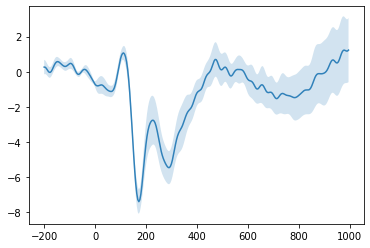

In [44]:
times = np.arange(-200, 1000, 4)
plot_erp_results(erp, times)

#### 绘制立即重复观看熟悉面孔条件下的ERP

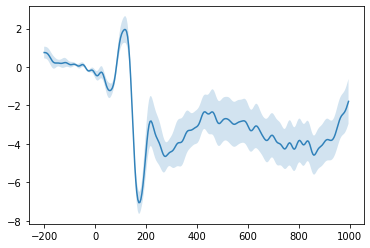

In [45]:
plot_erp_results(erp_rep, times)

#### 定义一个两条件ERP结果可视化函数plot_erp_2cons_results()  
其包含两条件之间的统计分析与可视化的功能  
**注意**：这里未对结果进行矫正（主要原因是示例中仅用了8个被试的数据）  
可以根据Part3部分的内容自行添加对结果的矫正

In [46]:
def plot_erp_results(erp1, erp2, times, con_labels=['Condition1', 'Condition2'], 
                     p_threshold=0.05):
    
    """
    参数：
        erp1: shape为[n_subs, n_times]的矩阵，对应每个被试条件1下的ERP
        erp2: shape为[n_subs, n_times]的矩阵，对应每个被试条件2下的ERP
        con_labels: 一个List或array，[条件1名称，条件2名称]，
                    默认为['Condition1', 'Condition2']
        p_threshold : 一个浮点型数字，默认为0.05，代表p值的阈值
        times: shape为[n_times]的array，代表时间点（对应x轴的时间范围及时间点）
    """
    
    n_subjects = np.shape(erp)[0]
    
    # 被试ERP均值
    avg1 = np.average(erp1, axis=0)
    avg2 = np.average(erp2, axis=0)
    # ERP的标准误SEM
    err1 = np.std(erp1, axis=0, ddof=0)/np.sqrt(n_subjects)
    err2 = np.std(erp2, axis=0, ddof=0)/np.sqrt(n_subjects)
    
    # 统计分析
    t_vals, p_vals = ttest_rel(erp1, erp2, axis=0)
    # FDR矫正
    # rejects, p_fdr_corrected = fdr_correction(p_vals, alpha=p_threshold)
    
    # 绘制显著性区域标记
    for i, p_val in enumerate(p_vals):
        if p_val < 0.05:
            plt.axvline(x=times[i], color='grey', alpha=0.1)
    
    # 绘制带SEM的ERP
    plt.fill_between(times, avg1+err1, avg1-err1, alpha=0.2, label=con_labels[0])
    plt.fill_between(times, avg2+err2, avg2-err2, alpha=0.2, label=con_labels[1])
    plt.plot(times, avg1, alpha=0.9)
    plt.plot(times, avg2, alpha=0.9)
    
    plt.legend()
    plt.show()

#### 统计并绘制首次观看与立即重复观看熟悉面孔两条件下的ERP

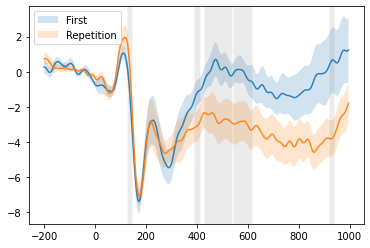

In [47]:
plot_erp_results(erp, erp_rep, times, con_labels=['First', 'Repetition'], 
                 p_threshold=0.05)

# Part 6 时频分析

#### 这里也使用Demo数据2作为示例  
##### 分别对实验中首次观看熟悉面孔与立即重复观看熟悉面孔两条件下的数据进行时频分析

### 数据读取与时频分析

In [48]:
# 初始化2个变量分别存储每个被试两条件下的时频分析结果
# 8 - n_subjects, 14 - n_freqs， 500 - n_times
tfr = np.zeros([8, 70, 14, 500])
tfr_rep = np.zeros([8, 70, 14, 500])

# 逐被试迭代
for sub in range(8):
    
    # 读取该被试的数据
    with h5py.File('demo_data1/sub' + str(sub + 1) + '.h5', 'r') as f:
        subdata = np.array(f['data'])
        subdata_rep = np.array(f['data_rep'])
        f.close()
    # 数据的shape从[n_channels, n_times, n_trials]转换成[n_trials, n_channels, n_times]
    subdata = np.transpose(subdata, (2, 0, 1))
    subdata_rep = np.transpose(subdata_rep, (2, 0, 1))
    
    # 设定一些时频分析的参数
    # 频段选取4-30Hz
    freqs = np.arange(4, 32, 2)
    n_cycles = freqs / 2.
    # 时频分析
    # 使用MNE的time_frequency模块下的tfr_arrayy_morlet()函数
    # 其输入为[n_epochs, n_channels, n_times]的array
    # 同时接着依次传入数据采样率、计算频率、周期数和输出数据类型
    subtfr = tfr_array_morlet(subdata, 250, freqs, n_cycles, output='power')
    subtfr_rep = tfr_array_morlet(subdata_rep, 250, freqs, n_cycles, output='power')
    # 此时返回的tfr的shape为[n_trials, n_channels, n_freqs, n_times]
    # 这里，对试次与导联维度平均传入tfr或tfr_rep变量中
    tfr[sub] = np.average(subtfr, axis=0)
    tfr_rep[sub] = np.average(subtfr_rep, axis=0)
    # 基线校正，这里使用'logratio'方法，即除以基线均值并取log
    # 取基线为-100到0ms
    for chl in range(70):    
        for freq in range(len(freqs)):
            tfr[sub, chl, freq] = 10 * np.log10(tfr[sub, chl, freq] / 
                                  np.average(tfr[sub, chl, freq, 100:125]))
            tfr_rep[sub, chl, freq] = 10 * np.log10(tfr_rep[sub, chl, freq] /
                                      np.average(tfr_rep[sub, chl, freq, 100:125]))

这里以第50个导联的两条件下-200ms到1000ms的时频分析结果作为后面统计分析与可视化的示例

In [49]:
tfr_No50 = tfr[:, 49, :, 75:375]
tfr_rep_No50 = tfr_rep[:, 49, :, 75:375]

### 统计分析与结果可视化

#### 首先定义一个单条件时频分析绘图函数plot_tfr_results()  
其包含统计分析与可视化的功能，并且结果进行了cluster-based permutation test

In [50]:
def plot_tfr_results(tfr, freqs, times, p=0.01, clusterp=0.05, clim=[-4, 4]):
    
    """
    参数：
        tfr : shape为[n_subs, n_freqs, n_times]的矩阵，代表时频分析的结果
        freqs : shape为[n_freqs]的array，代表时频分析的频率（对应y轴的频率范围及频率点）
        times : shape为[n_times]的array，代表时频分析的时间点（对应x轴的时间范围及时间点）
        p : 一个浮点型数字，默认为0.01，代表p值的阈值
        clusterp : 一个浮点型数字，默认为0.05，代表cluster层面p值的阈值
        clim : 一个List或array，[最小值，最大值]，默认为[-4, 4]，代表颜色条的上下边界
    """
    
    n_freqs = len(freqs)
    n_times = len(times)
    
    # 统计分析
    # 注意：由于进行了cluster-based permutation test，需要运行较长时间
    # 这里使用NeuroRA的stuff模块下的clusterbased_permutation_2d_1samp_2sided()函数
    # 其返回的stats_results为一个shape为[n_freqs, n_times]的矩阵
    # 该矩阵中不显著的点的值为0，显著大于0的点的值为1，显著小于0的点的值为-1
    # 这里iter设成100是为了示例运行起来快一些，建议1000
    stats_results = clusterbased_permutation_2d_1samp_2sided(tfr, 0, 
                                                        p_threshold=p,
                                                        clusterp_threshold=clusterp,
                                                        iter=100)
    
    # 时频分析结果可视化
    fig, ax = plt.subplots(1, 1)
    # 勾勒显著性区域
    padsats_results = np.zeros([n_freqs + 2, n_times + 2])
    padsats_results[1:n_freqs + 1, 1:n_times + 1] = stats_results
    x = np.concatenate(([times[0]-1], times, [times[-1]+1]))
    y = np.concatenate(([freqs[0]-1], freqs, [freqs[-1]+1]))
    X, Y = np.meshgrid(x, y)
    ax.contour(X, Y, padsats_results, [0.5], colors="red", alpha=0.9, 
               linewidths=2, linestyles="dashed")
    ax.contour(X, Y, padsats_results, [-0.5], colors="blue", alpha=0.9,
               linewidths=2, linestyles="dashed")
    # 绘制时频结果热力图
    im = ax.imshow(np.average(tfr, axis=0), cmap='RdBu_r', origin='lower', 
                   extent=[times[0], times[-1], freqs[0], freqs[-1]], clim=clim)
    ax.set_aspect('auto')
    cbar = fig.colorbar(im)
    cbar.set_label('dB')
    ax.set_xlabel('Time (ms)')
    ax.set_ylabel('Frequency (Hz)')
    plt.show()

#### 统计并绘制首次观看熟悉面孔条件下的时频分析结果


Permutation test

Side 1 begin:
Calculating: [====================================================================================================] 100.00%
Side 1 finished!

Side 2 begin:

Calculating: [====================================================================================================] 100.00%
Side 2 finished!

Cluster-based permutation test finished!



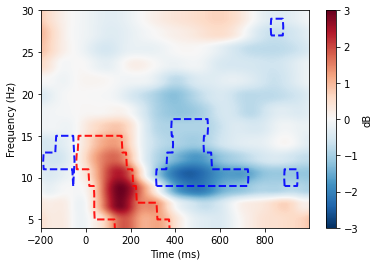

In [51]:
freqs = np.arange(4, 32, 2)
times = np.arange(-200, 1000, 4)
plot_tfr_results(tfr_No50, freqs, times, p=0.01, clusterp=0.05, clim=[-3, 3])

#### 统计并绘制立即重复观看熟悉面孔条件下的时频分析结果


Permutation test

Side 1 begin:
Calculating: [====================================================================================================] 100.00%
Side 1 finished!

Side 2 begin:

Calculating: [====================================================================================================] 100.00%
Side 2 finished!

Cluster-based permutation test finished!



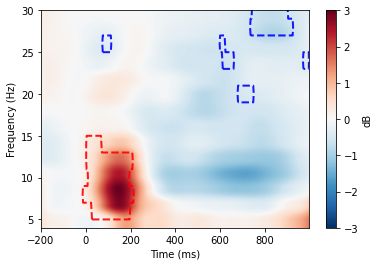

In [52]:
plot_tfr_results(tfr_rep_No50, freqs, times, p=0.01, clusterp=0.05, clim=[-3, 3])

#### 再定义一个两条件时频分析结果差异的绘图函数plot_tfr_diff_results()  
这里的差异用tfr1 - tfr2计算得到   
该函数包含统计分析与可视化的功能，并且结果进行了cluster-based permutation test

In [53]:
def plot_tfr_diff_results(tfr1, tfr2, freqs, times, p=0.01, clusterp=0.05, 
                          clim=[-2, 2]):
    
    """
    参数：
        tfr1 : shape为[n_subs, n_freqs, n_times]的矩阵，代表条件1下时频分析的结果
        tfr2 : shape为[n_subs, n_freqs, n_times]的矩阵，代表条件2下时频分析的结果
        freqs : shape为[n_freqs]的array，代表时频分析的频率（对应y轴的频率范围及频率点）
        times : shape为[n_times]的array，代表时频分析的时间点（对应x轴的时间范围及时间点）
        p : 一个浮点型数字，默认为0.01，代表p值的阈值
        clusterp : 一个浮点型数字，默认为0.05，代表cluster层面p值的阈值
        clim : 一个List或array，[最小值，最大值]，默认为[-2, 2]，代表颜色条的上下边界
    """
    
    n_freqs = len(freqs)
    n_times = len(times)
    
    # 统计分析
    # 注意：由于进行了cluster-based permutation test，需要运行较长时间
    # 这里使用NeuroRA的stuff模块下的clusterbased_permutation_2d_2sided()函数
    # 其返回的stats_results为一个shape为[n_freqs, n_times]的矩阵
    # 该矩阵中不显著的点的值为0，条件1显著大于条件2的点的值为1，条件1显著小于条件2的点的值为-1
    # 这里iter设成100是为了示例运行起来快一些，建议1000
    stats_results = clusterbased_permutation_2d_2sided(tfr1, tfr2, 
                                                       p_threshold=p,
                                                       clusterp_threshold=clusterp,
                                                       iter=100)
    
    # 计算△tfr
    tfr_diff = tfr1 - tfr2
    
    # 时频分析结果可视化
    fig, ax = plt.subplots(1, 1)
    # 勾勒显著性区域
    padsats_results = np.zeros([n_freqs + 2, n_times + 2])
    padsats_results[1:n_freqs + 1, 1:n_times + 1] = stats_results
    x = np.concatenate(([times[0]-1], times, [times[-1]+1]))
    y = np.concatenate(([freqs[0]-1], freqs, [freqs[-1]+1]))
    X, Y = np.meshgrid(x, y)
    ax.contour(X, Y, padsats_results, [0.5], colors="red", alpha=0.9, 
               linewidths=2, linestyles="dashed")
    ax.contour(X, Y, padsats_results, [-0.5], colors="blue", alpha=0.9,
               linewidths=2, linestyles="dashed")
    # 绘制时频结果热力图
    im = ax.imshow(np.average(tfr_diff, axis=0), cmap='RdBu_r', origin='lower', 
                   extent=[times[0], times[-1], freqs[0], freqs[-1]], clim=clim)
    ax.set_aspect('auto')
    cbar = fig.colorbar(im)
    cbar.set_label('$\Delta$ dB')
    ax.set_xlabel('Time (ms)')
    ax.set_ylabel('Frequency (Hz)')
    plt.show()

#### 统计并绘制首次观看与立即重复观看熟悉面孔两条件下的时频分析结果差异


Permutation test

Side 1 begin:
Calculating: [====================================================================================================] 100.00%
Side 1 finished!

Side 2 begin:

Calculating: [====================================================================================================] 100.00%
Side 2 finished!

Cluster-based permutation test finished!



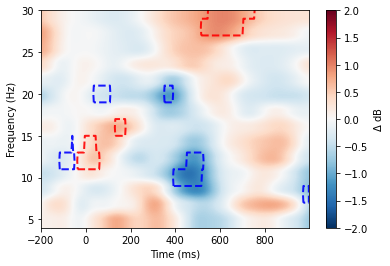

In [54]:
freqs = np.arange(4, 32, 2)
times = np.arange(-200, 1000, 4)
plot_tfr_diff_results(tfr_No50, tfr_rep_No50, freqs, times, 
                      p=0.05, clusterp=0.05, clim=[-2, 2])

# Part 7 基于分类的脑电解码

#### 这里使用Demo数据2用作脑电解码的示例

关于基于分类的脑电解码（classification-based EEG decoding）以及基于NeuroRA进行实现  
详情可以看路同学公众号曾经的一个推送：  
> [《*讲座录屏分享|基于NeuroRA解码大脑对信息的时序编码过程*》](https://mp.weixin.qq.com/s?__biz=MzUxMDYzNDU3MQ==&mid=2247484670&idx=1&sn=608d5b4055b1bf8eacb628fed5574a18&chksm=f97ebbdace0932ccb07a3a88a9e4a1377ac4e3c76e68122388a33a342080ff91d7d8f0f39e76&token=671900663&lang=zh_CN#rd)

### 读取数据和用于分类的标签

In [55]:
# 5个被试的编号
subs = ["201", "202", "203", "204", "205"]

# 初始化三个变量data、label_ori和label_pos
# 分别用于后续存储脑电数据、朝向的标签和位置的标签
data = np.zeros([5, 640, 27, 500])
label_ori = np.zeros([5, 640])
label_pos = np.zeros([5, 640])

# 对5个被试进行遍历
for i, sub in enumerate(subs):

    # 读取单个被试的数据
    subdata = sio.loadmat("demo_data2/data/ERP" + sub + ".mat")["filtData"]
    # subdata的shape为[640, 27, 750]
    # 640 - 试次数； 27 - 导联数； 750 - 时间点数（从-1.5s到1.5s）

    # 取-0.5s到1.5s的数据
    subdata = subdata[:, :, 250:]
    
    # 读取朝向和位置标签
    sublabel_ori = np.loadtxt("demo_data2/labels/ori_" + sub + ".txt")[:, 1]
    sublabel_pos = np.loadtxt("demo_data2/labels/pos_" + sub + ".txt")[:, 1]
    
    data[i] = subdata
    label_ori[i] = sublabel_ori
    label_pos[i] = sublabel_pos

### 逐时间点解码与结果可视化

#### 逐时间点解码即为对逐个时间点的数据进行分类解码

对朝向信息进行解码与结果可视化

Calculating: [====================================================================================================] 100.00%
Decoding finished!


Permutation test
Calculating: [====================================================================================================] 100.00%
Cluster-based permutation test finished!



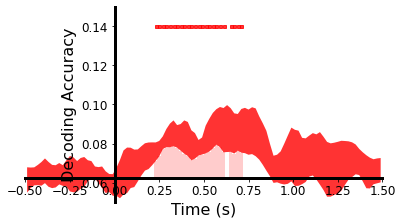

In [56]:
# 逐时间点解码
# 这里使用NeuroRA的decoding模块下的tbyt_decoding_kfold()函数进行逐时间点解码
# 传入数据（shape为[n_subs, n_trials, n_channels, n_times]）、对应每个试次的标签
# 以及一些其他参数，包括n=16 - 分类类别数为16（共16中朝向）、navg=13 - 对13个试次进行一次平均、
# time_win=5 - 时间窗为5（即5个时间点的数据进行一次平均）、
# time_step=5 - 时间步长为5（即每间隔5个时间点进行一次解码）、
# nfolds=3 & nrepeats=10 - 进行10次3折的交叉验证、smooth=True - 对结果进行平滑处理
accs_ori = tbyt_decoding_kfold(data, label_ori, n=16, navg=13, time_win=5, time_step=5, 
                               nfolds=3, nrepeats=10, smooth=True)

# 结果统计与可视化
# 这里使用NeuroRA的decoding模块下的plot_tbyt_decoding_acc()函数进行统计分析与可视化
# 其要求输入解码的结果（shape为[n_subs, n_results_times]）和一些其他参数：
# start_time=-0.5 - 解码结果的开始时间为-0.5s、end_time=1.5 - 解码结果的结束时间为1.5s、
# time_interval=0.02 - 两解码时间间隔为0.02s
#（由于时间窗为5，数据原采样率为250Hz，5*(1/250)=0.02s）、
# chance=0.0625 - 随机水平的分类准确率为0.0625（16个朝向，即1/16）、p=0.05 - p值的阈值、
# cbpt=True - 进行cluster-based permutation test、
# stats_time=[0, 1.5] - 统计0-1.5s的解码结果、
# xlim=[-0.5, 1.5] - x轴显示范围从-0.5到1.5、ylim=[0.05, 0.15] - y轴显示范围从0到1.5
plot_tbyt_decoding_acc(accs_ori, start_time=-0.5, end_time=1.5, time_interval=0.02, 
                       chance=0.0625, p=0.05, cbpt=True, stats_time=[0, 1.5], 
                       xlim=[-0.5, 1.5], ylim=[0.05, 0.15])

类似地对位置信息进行解码与结果可视化

Calculating: [====================================================================================================] 100.00%
Decoding finished!


Permutation test
Calculating: [====================================================================================================] 100.00%
Cluster-based permutation test finished!



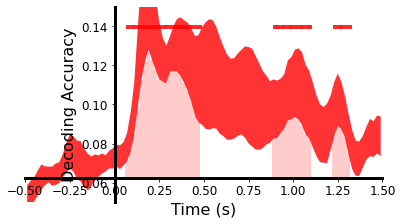

In [57]:
# 逐时间点解码
accs_pos = tbyt_decoding_kfold(data, label_pos, n=16, navg=13, time_win=5, time_step=5, 
                               nfolds=3, nrepeats=10, smooth=True)

# 结果统计与可视化
plot_tbyt_decoding_acc(accs_pos, start_time=-0.5, end_time=1.5, time_interval=0.02, 
                       chance=0.0625, p=0.05, cbpt=True, stats_time=[0, 1.5], 
                       xlim=[-0.5, 1.5], ylim=[0.05, 0.15])

### 跨时域解码与结果可视化

#### 跨时域解码即为对任意时间点的数据进行分类器训练都用来测试其他所有时间点的数据

对朝向信息进行解码与结果可视化


Decoding
Calculating: [====================================================================================================] 100.00%
Decoding finished!


Permutation test
Calculating: [====================================================================================================] 100.00%
Cluster-based permutation test finished!



/Users/zitonglu/anaconda3/lib/python3.7/site-packages/neurora/rsa_plot.py:877: UserWarning: No contour levels were found within the data range.
  linestyles="dashed")


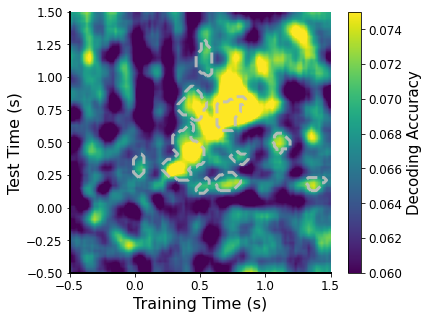

In [58]:
# 跨时域解码
# 这里使用NeuroRA的decoding模块下的ct_decoding_kfold()函数进行跨时域解码
accs_crosstime_ori = ct_decoding_kfold(data, label_ori, n=16, navg=13,
                                       time_win=5, time_step=5, 
                                       nfolds=3, nrepeats=10, smooth=True)

# 结果统计与可视化
# 这里使用NeuroRA的decoding模块下的plot_ct_decoding_acc()函数进行统计分析与可视化
plot_ct_decoding_acc(accs_crosstime_ori, start_timex=-0.5, end_timex=1.5, 
                     start_timey=-0.5, end_timey=1.5,
                     time_intervalx=0.02, time_intervaly=0.02, 
                     chance=0.0625, p=0.05, cbpt=True,
                     stats_timex=[0, 1.5], stats_timey=[0, 1.5], 
                     xlim=[-0.5, 1.5], ylim=[-0.5, 1.5], clim=[0.06, 0.075])

类似地对位置信息进行解码与结果可视化


Decoding
Calculating: [====================================================================================================] 100.00%
Decoding finished!


Permutation test
Calculating: [====================================================================================================] 100.00%
Cluster-based permutation test finished!



/Users/zitonglu/anaconda3/lib/python3.7/site-packages/neurora/rsa_plot.py:877: UserWarning: No contour levels were found within the data range.
  linestyles="dashed")


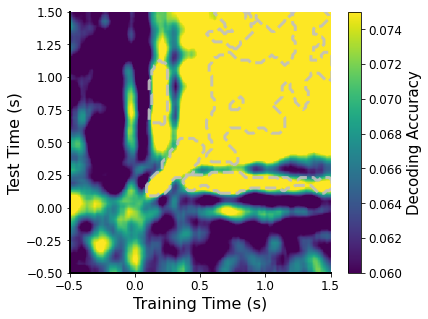

In [59]:
# 跨时域解码
accs_crosstime_pos = ct_decoding_kfold(data, label_pos, n=16, navg=13,
                                       time_win=5, time_step=5, 
                                       nfolds=3, nrepeats=10, smooth=True)

# 结果统计与可视化
plot_ct_decoding_acc(accs_crosstime_pos, start_timex=-0.5, end_timex=1.5, 
                     start_timey=-0.5, end_timey=1.5,
                     time_intervalx=0.02, time_intervaly=0.02, 
                     chance=0.0625, p=0.05, cbpt=True,
                     stats_timex=[0, 1.5], stats_timey=[0, 1.5], 
                     xlim=[-0.5, 1.5], ylim=[-0.5, 1.5], clim=[0.06, 0.075])

**注意1**：Demo数据1也同样可以用基于分类解码的方式来探究对熟悉面孔首次观看与重复观看两条件下的大脑时序表征差异  
欢迎自行依据上述代码进行举一反三

**注意2**：在NeuroRA的decoding模块下的相关函数，用户在使用时，输入的数据无需各类别试次完全一致，函数内部均会对不同类别的试次数进行内部均衡操作，即，如果你输入的数据n_trials=50  其中label为1的有20个试次，label为2的有30个试次，那实际NeuroRA函数里面进行运算时，每次迭代中都是从label为2的30个试次里面随机抽20个，加个label为1的20个试次，共40个试次做2分类，来保证每次分类的类别均衡。

# Part 8 表征相似性分析

#### 这里也使用Demo数据2进行表征相似性分析的示例

关于表征相似性分析（representational similarity analysis）的方法介绍以及基于NeuroRA的实现  
详情可以看路同学公众号一系列的推送：  
> [《讲座录屏分享|基于NeuroRA进行认知神经科学中的表征分析》](https://mp.weixin.qq.com/s?__biz=MzUxMDYzNDU3MQ==&mid=2247484332&idx=1&sn=6eddcf2a95a723ac517776781a7fcec7&chksm=f97ebc88ce09359e787c2748f3c2f1e763136169eee7eefd10c665a5a1daad2ff41986231f44&token=671900663&lang=zh_CN#rd)  
> [《又又又官方强推！ NeuroRA进行脑电RSA相关计算推荐流程【Only 3行代码】》](https://mp.weixin.qq.com/s?__biz=MzUxMDYzNDU3MQ==&mid=2247484732&idx=1&sn=480ffc0d970917f9314a64d1db9828fe&chksm=f97eba18ce09330ea15da580c1d7a4775294ccb3940680c00a87030359dcae7c59a3204b6c8f&token=671900663&lang=zh_CN#rd)

### 计算脑电表征不相似性矩阵

表征不相似性矩阵 - representational dissimialrity matrix, RDM  
根据16个朝向和16个位置，分别计算逐时间点的16×16的表征朝向信息的脑电RDM和表征位置信息的脑电RDM

In [60]:
n_subs = 5
n_trials = 640
# 首先对数据进行重新划分
# 分别获取16个朝向条件下的脑电数据和16个位置条件下的脑电数据
# 初始化两个变量data_ori和data_pos分别用于存储朝向和位置的数据
data_ori = np.zeros([16, n_subs, 40, 27, 500], dtype=np.float)
data_pos = np.zeros([16, n_subs, 40, 27, 500], dtype=np.float)
for sub in range(n_subs):
    index_ori = np.zeros([16], dtype=int)
    index_pos = np.zeros([16], dtype=int)
    for i in range(n_trials):
        ori = int(label_ori[sub, i])
        pos = int(label_pos[sub, i])
        data_ori[ori, sub, index_ori[ori]] = data[sub, i]
        index_ori[ori] = index_ori[ori] + 1
        data_pos[pos, sub, index_pos[pos]] = data[sub, i]
        index_pos[pos] = index_pos[pos] + 1
        
# 计算RDMs
# 计算朝向表征的RDMs
RDMs_ori = eegRDM(data_ori, sub_opt=1, chl_opt=0, time_opt=1, time_win=5, time_step=5)
# 计算位置表征的RDMs
RDMs_pos = eegRDM(data_pos, sub_opt=1, chl_opt=0, time_opt=1, time_win=5, time_step=5)
# 返回的RDMs_ori和RDMs_pos的shape均为[n_subs即5, n_results_time即100, 16, 16]


Computing RDMs
Calculating: [====================================================================================================] 100.00%
RDMs computing finished!

Computing RDMs
Calculating: [====================================================================================================] 100.00%
RDMs computing finished!


### 构建编码模型表征不相似性矩阵

这里基于两角度越接近相似性约高、两角度越不接近相似性越低的假设  
构建了一个编码模型RDM，此例中，对朝向和位置信息均适用

In [61]:
# 构建编码模型RDM
model_RDM = np.zeros([16, 16])
for i in range(16):
    for j in range(16):
        diff = np.abs(i - j)
        if diff <= 8:
            model_RDM[i, j] = diff / 8
        else:
            model_RDM[i, j] = (16 - diff) / 8

可视化编码模型RDM

1


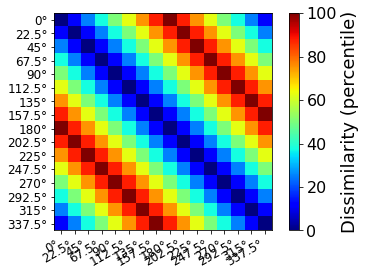

0

In [62]:
# 条件标签（16个角度）
conditions = ["0°", "22.5°", "45°", "67.5°", "90°", "112.5°", "135°", "157.5°", "180°",
              "202.5°", "225°", "247.5°", "270°", "292.5°", "315°", "337.5°"]

# 绘图
# 使用NeuroRA的rsa_plot模块下的plot_rdm()函数
plot_rdm(model_RDM, percentile=True, conditions=conditions)

### 相似性分析

使用编码模型RDM分别与朝向表征的脑电RDMs和位置表征的脑电RDMs计算相似性  
来时序上追踪大脑何时符合对朝向的编码、何时符合对位置的编码

In [63]:
# 相似性分析
# 使用NeuroRA的corr_cal_by_rdm模块下的rdms_corr()函数

# 计算编码模型RDM与朝向表征的脑电RDMs之间的相似性
similarities_ori = rdms_corr(model_RDM, RDMs_ori)
# 计算编码模型RDM与位置表征的脑电RDMs之间的相似性
similarities_pos = rdms_corr(model_RDM, RDMs_pos)


Computing similarities

Computing finished!

Computing similarities

Computing finished!


### 统计分析与结果可视化

基于RSA的大脑对朝向信息编码的结果可视化


Permutation test
Calculating: [====================================================================================================] 100.00%
Cluster-based permutation test finished!



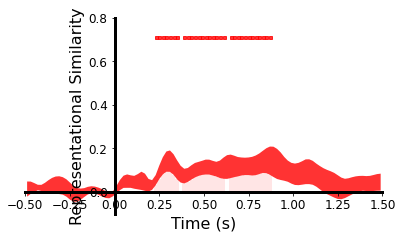

0

In [64]:
# 使用NeuroRA的rsa_plot模块下的plot_tbytsim_withstats()函数
# 用法与plot_tbyt_decoding_acc()函数类似
plot_tbytsim_withstats(similarities_ori, start_time=-0.5, end_time=1.5, 
                       time_interval=0.02, smooth=True, p=0.05, cbpt=True, 
                       stats_time=[0, 1.5], xlim=[-0.5, 1.5], ylim=[-0.1, 0.8])

基于RSA的大脑对位置信息编码的结果可视化


Permutation test
Calculating: [====================================================================================================] 100.00%
Cluster-based permutation test finished!



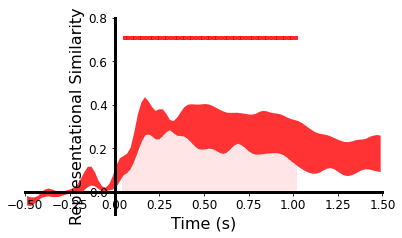

0

In [65]:
plot_tbytsim_withstats(similarities_pos, start_time=-0.5, end_time=1.5, 
                       time_interval=0.02, smooth=True, p=0.05, cbpt=True, 
                       stats_time=[0, 1.5], xlim=[-0.5, 1.5], ylim=[-0.1, 0.8])

其实，RSA也能进行类似基于分类解码的跨时域分析  
详情可以参考路同学公众号的推送：  
> [*《使用PyCTRSA实现全新基于跨时域表征相似性分析的EEG/MEG解码》*](https://mp.weixin.qq.com/s?__biz=MzUxMDYzNDU3MQ==&mid=2247484611&idx=1&sn=8b80b17100b1a196972dbacc53f671d8&chksm=f97ebbe7ce0932f10aead12c687d46beef8165221339cb2d0c69edf1d66cba34331fd770fda6&token=671900663&lang=zh_CN#rd)